--- 
description: In this tutorial, we will solve the Multi-Car Paint Shop (MCPS) problem using JijZept, based on the work of Sheir Yarkoni,...
---

# Multi-Car Paint Shop Problem
In this tutorial, we will solve the Multi-Car Paint Shop (MCPS) problem using JijZept, based on the work of Sheir Yarkoni, et al. [[1](https://arxiv.org/abs/2109.07876)].
The Multi-Car Paint Shop (MCPS) problem is to minimize the number of color switchings when painting multiple car models at a factory.


## Problem Setting
The Multi-Car Paint Shop (MCPS) problem is to optimize color switching when painting multiple car models at a factory, as described above.
In the painting process, there is a base coat, whose color is determined by the customer's request, and a coating called filler, which is applied underneath the base coat.
The color of the filler is determined by the color of the base coat, which must be painted black for darker colors and white for lighter colors.
The Multi-Car Paint Shop (MCPS) problem is an optimization problem for this filler coloring. 
It is necessary to paint as many cars in the queue as possible with the same filler color while satisfying the constraint that the correct filler color is applied to the car. 
The problem is to paint the car with the correct color and to reduce the number of times the paint color is switched.

Let us consider an example.
For simplicity, we consider only two car models $C_1, C_2$.
Suppose that six cars come into the queue waiting to be painted in the order $C_1, C_1, C_2, C_2, C_1, C_2$.
Let $k(C_l)\ (l = 1,2)$ denote the number of cars to paint car model $C_l$ in black.
Suppose that $k(C_1) = 2,k(C_2) = 1$, i.e., two of car model 1 must be painted black and one of car model 2 must be painted black.
When we write $B$ for black and $W$ for white, the least number of repaints will be $B,B,B,W,W,W$ for the incoming cars.

## Mathematical model
We consider $N$ cars come into the queue and there are $n$ car models.

### Decision variable
Binary variables $q_i$ are defined as:

$$
q_{i} = \begin{cases}
1~\text{$i$th car is painted black}\\
0~\text{otherwise}\\
\end{cases}
$$

for all $i \in \{0, ..., N-1\}$.

### Constraints
We have to consider one constraint;

1. The filler must be painted in the correct number corresponding to the order for each car model.

The number of vehicles of car model $C_l$ that are painted black must equal $k(C_l)$.
We can formulate this constraint as an independent $K$-hot constraint on car models $C_l$.
Since we are now using the binary variable $q_i$, which is 1 if car $i$ is black, we know that when we sum over all the binary variables for cars belonging to car type $C_l$, the sum should be $k(C_l)$.
Therefore, the constraint is

$$
\sum_{i\in C_l} q_i = k(C_l) \ \forall\ l
$$


### Objective function
The objective of this problem is to reduce the number of color switching as much as possible, in other words, the objective is to make the color of successive cars the same.
The property of being the same color as its neighbors can be formulated using the ferromagnetic formulation in the Ising model
The ferromagnetic formulation is

$$
H_A = -\sum_{i=0}^{N-2}s_is_{i+1}.
$$

where $s_i\in\{-1,1\}$ is spin variable and there is a relationship $s_i = 2q_i - 1$ between $s_i$ and $q_i$.
Therefore, we can rewrite the objective function of this problem using $q_i$ as

$$
H_A = -\sum_{i=0}^{N-2}s_is_{i+1} = -\sum_{i=0}^{N-2}(2q_i - 1)(2q_{i+1} - 1)
$$

In conclusion, the Multi-Car Paint Shop (MCPS) problem can be formulated as

$$
\begin{aligned}
&\text{Minimize}\quad H_A = -\sum_{i=0}^{N-2}(2q_i - 1)(2q_{i+1} - 1) \\
&\text{subject to } \sum_{i\in C_l} q_i = k(C_l)　\forall\  l
\end{aligned}
$$

## Modeling by JijModeling
Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

N = jm.Placeholder('N') # Number of cars
n = jm.Placeholder('n') # Number of car models
C = jm.Placeholder('C',ndim=2) # indices of each car models
K = jm.Placeholder('K',ndim=1) # Number of black cars for each car models

q = jm.BinaryVar('q', shape=(N,))

j = jm.Element('j', belong_to=(0,N-1))
c = jm.Element('c', belong_to=(0,n))
l = jm.Element('l', belong_to=C[c]) 

The data of the number of cars for each car model becomes like
```python
{1 : [0, 3, 8, 10], 2 :[1, 4, 6, 9, 12],3: [2, 5, 7, 11, 13]}
```
This data structure expresses that the key of the dictionary corresponds to car models and the value of the dictionary is the indices of each car model.
JijZept currently does not support dictionary data structure, so we have to convert this data into a list 
```python
[[0, 3, 8, 10], [1, 4, 6, 9, 12], [2, 5, 7, 11, 13]] 
```

`Placeholder` can also be used with such a  data structure.

Next, let us formulate our models using JijModeling.

In [2]:
problem = jm.Problem("multi car paint")

# Constraints
problem += jm.Constraint("N-hot constraint",jm.sum(l,q[l]) == K[c],forall=c)
# Objective function
problem += -jm.sum(j,(2*q[j] - 1)*(2*q[j+1] - 1))
problem

## Prepare an instance
The [1] uses real data, however, we create the random instance for this problem.

We consider the number of cars $N=30$ and the number of car models is $n=4$ as an example.

In [3]:
import numpy as np
num_carmodels = 4
num_cars = 30
sequence = np.random.choice(range(num_carmodels),num_cars)
carmodels_list = [[] for i in range(num_carmodels)]
for index,car_index in enumerate(sequence):
    carmodels_list[car_index].append(index)

In [4]:
num_blackcar = [int(np.ceil(len(cars)/2)) for cars in carmodels_list]
instance_data = {'N':num_cars, 'n':num_carmodels, 'K':num_blackcar, 'C':carmodels_list}

In [5]:
instance_data

{'N': 30,
 'n': 4,
 'K': [5, 2, 3, 6],
 'C': [[5, 11, 12, 15, 17, 19, 21, 26, 28],
  [6, 9, 22, 24],
  [0, 3, 8, 10, 13, 16],
  [1, 2, 4, 7, 14, 18, 20, 23, 25, 27, 29]]}

## Solve by JijZept's SA
We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [6]:
import jijzept as jz

In [7]:
# Please enter your `config.toml` path here.
config_path = './config.toml'

In [8]:
# set sampler
sampler = jz.JijSASampler(config=config_path)
# solve problem
results = sampler.sample_model(problem, instance_data, search = True)

## Check the results
Let us check the last 5 results in the parameter search.
`to_pandas` returns obtained results as a pandas dataframe.

In [10]:
max_show_num = 5
results.to_pandas().tail(max_show_num)

,solution[q],num_occurrences,energy,objective,constraint_forall,constraint_values,constraint_violation[N-hot constraint]
10,"(([1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 17, 18, 19...",1,-33.369553,-17.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
11,"(([1, 4, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21,...",1,-33.162659,-11.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
12,"(([0, 4, 5, 6, 13, 14, 15, 16, 19, 20, 21, 23,...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
13,"(([0, 1, 8, 10, 11, 12, 15, 18, 19, 20, 21, 22...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
14,"(([2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 18, 21, 22...",1,-33.231625,-13.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0


The results are in a COO format in `solution`.
We can also convert COO to dense matrix format with `.to_dense`.

If we would like to have feasible solutions, we can get them by taking out the solutions in which `constraint_violation[N-hot constraint]` is 0.

In [11]:
df = results.to_dense().to_pandas()
feasible_df = df[df["constraint_violation[N-hot constraint]"] == 0.0]
feasible_df

,solution[q],num_occurrences,energy,objective,constraint_forall,constraint_values,constraint_violation[N-hot constraint]
0,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",1,-15.448276,-13.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,-3.885532,-23.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
4,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,-10.366085,-19.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
7,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
8,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",1,-33.300587,-15.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
9,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
10,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",1,-33.369553,-17.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
11,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",1,-33.162659,-11.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
12,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0
13,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,-33.093693,-9.0,"{'N-hot constraint': [[1], [2], [0], [3]]}","{'N-hot constraint': [0.0, 0.0, 0.0, 0.0]}",0.0


The lowest objective is -25.0 in this, so let us check the result.

In [12]:
sol = feasible_df["solution[q]"][11]
sol

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

## Visualize results

Let us visualize the result.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

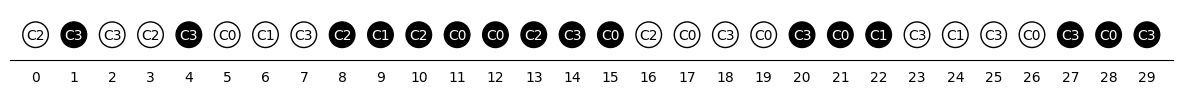

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.tick_params(labelleft=False,left=False,bottom=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)

for i in range(num_cars):
    position = (1.5*i, 0)
    circ = patches.Circle(xy=position, radius=0.5, fc= 'k' if sol[i] else 'w', ec='k')
    c_txt = plt.text(*position, 'C%s'%(sequence[i]), color = 'w' if sol[i] else 'k', horizontalalignment="center", verticalalignment="center")
    ax.add_patch(circ)
ax.set_xticks(np.arange(num_cars)*1.5, np.arange(num_cars),fontsize=10)   
ax.set_xlim(-1, 1.5*num_cars-0.5)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
plt.show()

The color switchings only appear two times in this result.

## References
[1] Sheir Yarkoni, et al., "[Multi-car paint shop optimization with quantum annealing](https://arxiv.org/abs/2109.07876)" (2019)